In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import math, os, h5py
import pandas as pd

import tensorflow as tf
import h5py
import os
from tensorflow import keras
from tensorflow.keras.constraints import Constraint
from tensorflow.keras import metrics, losses, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow import Variable
from tensorflow import linalg as la
from tensorflow.keras import initializers

from utils_v6 import *
from NNutils import *

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')

In [3]:
def Read_from_h5(INPUT_PATH, trim_list, read_keys=[], mass_min=None, mass_max=None, isdata=False):
    REF, W_REF = np.array([]), np.array([])
    i=0
    for process in trim_list:
        f = h5py.File(INPUT_PATH+process+'.h5', 'r')
        if len(read_keys)==0: 
            read_keys = list(f.keys())
            #print('keys: ', read_keys)
        idx_weight = np.argwhere(np.array(read_keys)=='weight').reshape(-1,)[0]
        read_file  = np.array([])
        mass_mask = np.ones(np.array(f.get(read_keys[0])).shape[0])>0
        if 'mass' in list(f.keys()):
            mass = np.array(f.get('mass')) 
            if mass_min!=None:
                mass_mask *= (mass>mass_min)
            if mass_max!=None:
                mass_mask *= (mass<mass_max)
        if np.sum(mass_mask)==0:
            f.close()
            continue
        if np.array(f.get(read_keys[0])).shape[0]==0: 
            f.close()
            continue
        #print(process)
        for p in read_keys:
            col = np.array(f.get(p)) 
            col = col[mass_mask]
            col = np.expand_dims(col, axis=1)
            if read_file.shape[0]==0:
                read_file = col
            else:
                read_file = np.concatenate((read_file, col), axis=1)
        f.close()
        if REF.shape[0]==0:
            REF    = np.delete(read_file, idx_weight, 1)#[:, :-1]
            W_REF  = read_file[:, idx_weight:(idx_weight+1)]
        else:
            REF    = np.concatenate((REF,    np.delete(read_file, idx_weight, 1)), axis=0)
            W_REF  = np.concatenate((W_REF,  read_file[:, idx_weight:(idx_weight+1)]), axis=0)
        i+=1
        
    return REF, W_REF

In [4]:
feature    = np.array([])
targets    = np.array([])
weights    = np.array([])
nuisance   = np.array([])
nu_list    = np.array([-3., -1., 1., 3.])
nu_std     = np.std(nu_list)
nu_list_std= nu_list*1./nu_std
plot=False
lumi_scale = 1
mass_cut = 200
# folder = '/eos/user/g/ggrosso/PhD/DiMuon_Scouting/root_to_h5/'
folder = '/eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale'
np.random.seed(1234)
REF, W_REF, Z_REF = np.array([]), np.array([]), np.array([])
# for year in ['2016', '2017', '2018']:
for year in ['2017', '2018']:
    #REF_y, W_REF_y = read_data_training_nu(folder, year, mass_cut, nu=0, muonpt_scale_str='0.0', trim_list=trim_list[year],
    #                                       columns_training=columns_training, columns_weight=columns_weight)
    mc_folder='%s/MC_%s_M200_final_match_muonPTscale_%s/'%(folder, year,'0.0')
    print('read', mc_folder)
    REF_y, W_REF_y = Read_from_h5(mc_folder, trim_list[year], read_keys=columns_training+['weight'], isdata=False)
    Z_REF_y = np.ones_like(W_REF_y)*year_label_dict[year]
    # if year == '2016':
    if year == '2017': #!!!temparary fix for the missng 2016
        REF, W_REF, Z_REF = REF_y, W_REF_y, Z_REF_y

    else:
        REF   = np.concatenate((REF, REF_y), axis=0)
        W_REF = np.concatenate((W_REF, W_REF_y), axis=0)
        Z_REF = np.concatenate((Z_REF, Z_REF_y), axis=0)

N_REF = REF.shape[0]
idx_REF = np.arange(N_REF)
#mean_REF = np.mean(REF, axis=0)
#std_REF = np.std(REF, axis=0)
for nu in nu_list:
    i = np.where(nu==nu_list)[0][0]
    if nu==0:
        muonpt_scale_str = '0.0'
    else:
        muonpt_scale_str=str(nu)
    nu_std = nu_list_std[i]
    DATA, W_DATA, Z_DATA = np.array([]), np.array([]), np.array([])
    # for year in ['2016', '2017', '2018']:
    for year in [ '2017', '2018']:
        #DATA_y, W_DATA_y = read_data_training_nu(folder, year, mass_cut, nu=nu, muonpt_scale_str=muonpt_scale_str, trim_list=trim_list[year],
        #                                     columns_training=columns_training, columns_weight=columns_weight)
        mc_folder='%s/MC_%s_M200_final_match_muonPTscale_%s/'%(folder,year,muonpt_scale_str)
        print('read', mc_folder)
        DATA_y, W_DATA_y = Read_from_h5(mc_folder, trim_list[year], read_keys=columns_training+['weight'], isdata=False)
        Z_DATA_y = np.ones_like(W_DATA_y)*year_label_dict[year]
        # if year == '2016':
        if year == '2017': #!!!temparary fix for the missng 2016
            DATA, W_DATA, Z_DATA = DATA_y, W_DATA_y, Z_DATA_y
        else:
            DATA   = np.concatenate((DATA, DATA_y), axis=0)
            W_DATA = np.concatenate((W_DATA, W_DATA_y), axis=0)
            Z_DATA = np.concatenate((Z_DATA, Z_DATA_y), axis=0)
    N_DATA = DATA.shape[0]
    idx_DATA = np.arange(N_DATA)
    np.random.shuffle(idx_REF)
    np.random.shuffle(idx_DATA)
    mask_REF   = (idx_REF<int(N_REF*lumi_scale))
    mask_DATA  = (idx_DATA<int(N_DATA*lumi_scale))
    feature_nu = np.concatenate((REF[mask_REF], DATA[mask_DATA]), axis=0)
    targets_nu = np.append(np.zeros(REF[mask_REF].shape[0]), np.ones(DATA[mask_DATA].shape[0]))
    yearlab_nu = np.append(Z_REF[mask_REF], Z_DATA[mask_DATA])
    nuisanc_nu = np.ones(feature_nu.shape[0])*nu_std
    weights_nu = np.append(W_REF[mask_REF], W_DATA[mask_DATA])
    if feature.shape[0]==0:
        feature = feature_nu
        targets = targets_nu
        weights = weights_nu
        yearlab = yearlab_nu
        nuisance= nuisanc_nu
    else:
        feature = np.concatenate((feature, feature_nu), axis=0)
        targets = np.concatenate((targets, targets_nu), axis=0)
        weights = np.concatenate((weights, weights_nu), axis=0)
        yearlab = np.concatenate((yearlab, yearlab_nu), axis=0)
        nuisance= np.concatenate((nuisance,nuisanc_nu), axis=0)
print(feature.shape)
del REF, W_REF, Z_REF


read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2017_M200_final_match_muonPTscale_0.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2018_M200_final_match_muonPTscale_0.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2017_M200_final_match_muonPTscale_-3.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2018_M200_final_match_muonPTscale_-3.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2017_M200_final_match_muonPTscale_-1.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2018_M200_final_match_muonPTscale_-1.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2017_M200_final_match_muonPTscale_1.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2018_M200_final_match_muonPTscale_1.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2017_M200_final_ma

In [6]:
print(weights.shape)
print(feature.shape)
print(targets.shape)
print(nu_list)
print(nu_list_std)

(27658665,)
(27658665, 6)
(27658665,)
[-3. -1.  1.  3.]
[-1.34164079 -0.4472136   0.4472136   1.34164079]


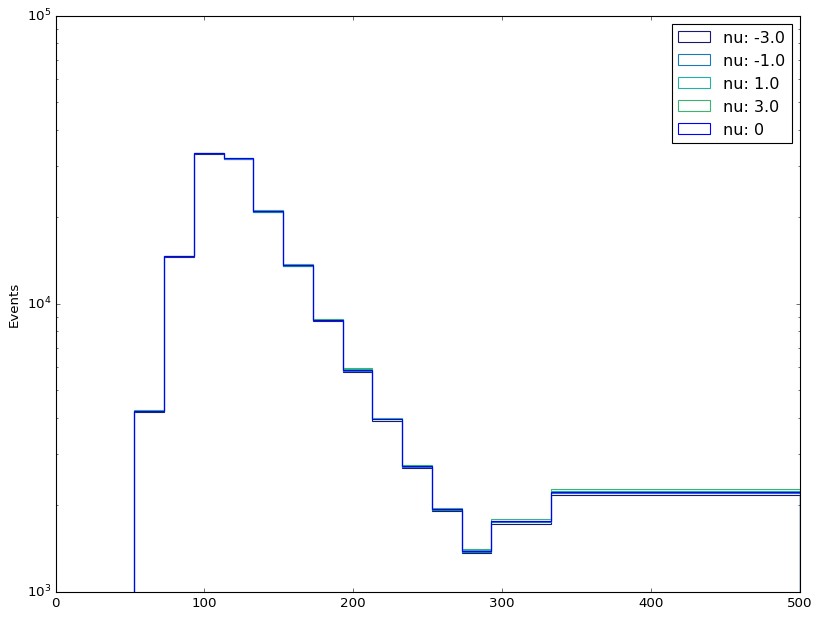

In [7]:
h_list = []
fig = plt.figure(figsize=(12, 9))
fig.patch.set_facecolor('white') 
bins = np.append(np.arange(33, 303, 20),np.array([333, 500]))
for i in range(len(nu_list)):
    nu = nu_list[i]
    nu_std = nu_list_std[i]
    pt = feature[:, 0]
    pt_nu = pt[(targets==1)*(nuisance==nu_std)]
    w = weights[(targets==1)*(nuisance==nu_std)]
    h = plt.hist(pt_nu, weights=w, bins=bins, label='nu: %s'%(str(nu)), histtype='step', color=colors[i])[0]
    h_list.append(h)
    #print(h)                                                                                                                                                                                  
pt    = feature[:, 0]
pt_nu = pt[(targets==0)]
w     = weights[(targets==0)]*1./len(nu_list)
h_0   = plt.hist(pt_nu, weights=w, bins=bins, label='nu: %s'%(str(0)), histtype='step')[0]
plt.ylabel('Events')
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

In [10]:
weights.shape

(27658665,)

/tmp/hhua/ipykernel_11781/119745450.py:22: RuntimeWarning: invalid value encountered in true_divide
  r = plt.errorbar(x, h_nu/h_0, yerr=h_nu/h_0*np.sqrt(h_nu2/(h_nu**2) + h_02/(h_0**2)),
/tmp/hhua/ipykernel_11781/119745450.py:22: RuntimeWarning: invalid value encountered in true_divide
  r = plt.errorbar(x, h_nu/h_0, yerr=h_nu/h_0*np.sqrt(h_nu2/(h_nu**2) + h_02/(h_0**2)),
/tmp/hhua/ipykernel_11781/119745450.py:22: RuntimeWarning: invalid value encountered in true_divide
  r = plt.errorbar(x, h_nu/h_0, yerr=h_nu/h_0*np.sqrt(h_nu2/(h_nu**2) + h_02/(h_0**2)),
/tmp/hhua/ipykernel_11781/119745450.py:22: RuntimeWarning: invalid value encountered in true_divide
  r = plt.errorbar(x, h_nu/h_0, yerr=h_nu/h_0*np.sqrt(h_nu2/(h_nu**2) + h_02/(h_0**2)),


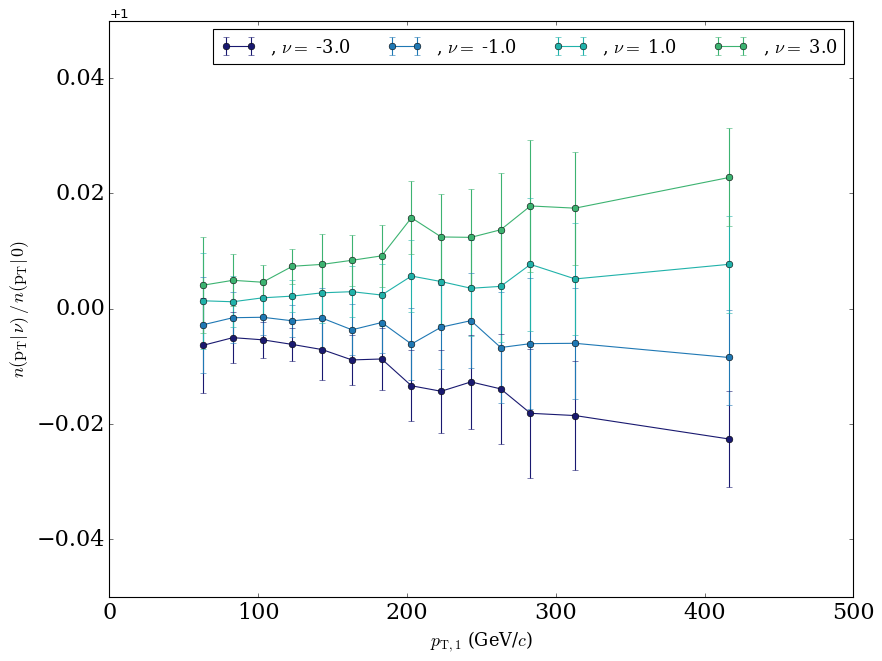

In [11]:
fig = plt.figure(figsize=(12, 9))
fig.patch.set_facecolor('white') 

bins = np.append(np.arange(33, 303, 20),np.array([333, 500])) #np.arange(33, 303, 20) creates an array of integers from 33 to 303 with a step of 20. This generates bin edges from 33 to 293 with a bin width of 20. np.array([333, 500]) adds two additional bin edges at 333 and 500.
x = 0.5*(bins[1:]+bins[:-1])

for i in range(len(nu_list)):
    idx_pt1 = 0
    nu = nu_list[i]
    nu_std = nu_list_std[i]
    nu_str = str(nu)
    pt = feature[:, 0]
    pt_0 = pt[(targets==0)*(nuisance==nu_std)]
    w_0 = weights[(targets==0)*(nuisance==nu_std)]
    pt_nu = pt[(targets==1)*(nuisance==nu_std)] #Guessing targets=1 mask for systematic variations
    w_nu = weights[(targets==1)*(nuisance==nu_std)]
    h_0   = plt.hist(pt_0,  weights=w_0,     bins=bins, alpha=0.)[0]
    h_02  = plt.hist(pt_0,  weights=w_0**2,  bins=bins, alpha=0.)[0]
    h_nu  = plt.hist(pt_nu,  weights=w_nu,    bins=bins, alpha=0.)[0]
    h_nu2 = plt.hist(pt_nu,  weights=w_nu**2, bins=bins, alpha=0.)[0]
    
    r = plt.errorbar(x, h_nu/h_0, yerr=h_nu/h_0*np.sqrt(h_nu2/(h_nu**2) + h_02/(h_0**2)),
                     label=r', $\nu=$ '+nu_str, marker='o', color=colors[i]) #plotting 
    i+=1
plt.ylabel(r'$n({\rm p_T}|\,\nu)\,/ \, n({\rm p_T}|\,0)$', fontsize=16, fontname='serif')
plt.xlabel(xlabel_dict['leadmupt'], fontsize=16, fontname='serif')
plt.ylim(0.95, 1.05)
#plt.xscale('log')
#plt.yscale('log')
plt.yticks(fontsize=20, fontname='serif')
plt.xticks(fontsize=20, fontname='serif')
font = font_manager.FontProperties(family='serif', size=16)
plt.legend(loc='best',ncol=4, prop=font)
plt.show()

In [8]:
# data preprocessing                                                                                                                                                                           
#standardize dataset #####################                                                                                                                                                     
for j in range(feature.shape[1]): #guessing j up to 6
    vec  = feature[:, j] #6 columns, 2435354 rows; represents one column which is all events here
    mean = mean_REF[j]
    std  = std_REF[j]
    if np.min(vec) < 0:
        vec = vec- mean
        vec = vec *1./ std
    elif np.max(vec) > 1.0:# Assume data is exponential -- just set mean to 1.                                                                                                                 
        vec = vec *1./ mean
    feature[:, j] = vec
#cols = [0, 1]# [PT1, PT2]                                                                                                                                                                     
feature = np.concatenate((feature[:, :2], np.expand_dims(yearlab, axis=1)), axis=1)
target  = np.stack([targets, weights, nuisance], axis=1)
print(feature.shape)
print(target.shape)

(27658665, 3)
(27658665, 3)


In [7]:
ay = np.array([[1,2], [3,4], [5,6]])
ay[2,1]
ay.shape

(3, 2)

In [10]:
# split training, validation and test                                                                                                                                                          
fraction_validation = 0.2
fraction_test       = 0.2
fraction_training   = 1 - fraction_validation - fraction_test

N   = feature.shape[0] #number of all events
idx = np.arange(N)
np.random.seed(0)
np.random.shuffle(idx)

mask_val   = (idx<int(N*fraction_validation))
mask_test  = (idx>=int(N*fraction_validation))*(idx<int(N*(fraction_validation+fraction_test)))
mask_train = (idx>=int(N*(fraction_validation+fraction_test)))

feature_test,  target_test  = feature[mask_test],  target[mask_test]
feature_train, target_train = feature[mask_train], target[mask_train]
feature_val,   target_val   = feature[mask_val],   target[mask_val]

feature_test,  target_test  = tf.convert_to_tensor(feature_test, dtype=tf.float32),  tf.convert_to_tensor(target_test, dtype=tf.float32)
feature_train, target_train = tf.convert_to_tensor(feature_train, dtype=tf.float32), tf.convert_to_tensor(target_train, dtype=tf.float32)
feature_val,   target_val   = tf.convert_to_tensor(feature_val, dtype=tf.float32), tf.convert_to_tensor(target_val, dtype=tf.float32)
print(feature_test.shape, feature_train.shape, feature_val.shape)

(5531733, 3) (16595199, 3) (5531733, 3)


In [11]:
# model                                                                                                                                                                                        
#inputsize = 3 # [PT1, PT2, YEAR] 
inputsize = 2 # [PT1, PT2] 
# layers    = [inputsize, 30,30, 1] 
layers    = [inputsize, 30,30,30, 30, 1] 
print('Layers:')
print(layers)
architecture  = ''
for l in layers:
    architecture += str(l)+'_'
print('Architecture:')
print(architecture)
nu_string = ''
for nu in nu_list:
    nu_string += str(nu)+'_'
print('nu list')
print(nu_string)
plot = True
total_epochs      = 1000 #The number of epochs is a hyperparameter that defines how many times the learning algorithm will work through the entire training dataset
patience          = 100
wc                = 10
L2                = None
poly_degree       = 1
activation        = 'sigmoid'
batch_fraction    = 0.5
learning_rate = 0.001
gather_after = int(1./batch_fraction)
# OUTPUT_PATH= '/eos/user/g/ggrosso/PhD/DiMuon_Scouting/muonpt_parametric_training_output_2016-17-18_Mcut200_lumi%iperc/'%(int(lumi_scale*100))
OUTPUT_PATH= './output/muonpt_parametric_training_output_2016-17-18_Mcut200_lumi%iperc/'%(int(lumi_scale*100))
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print('mk %s'%(OUTPUT_PATH))
input_shape  =  (None, inputsize)
model        = ParametricNet(input_shape, architecture=layers, activation=activation, l2=L2,
                               poly_degree=poly_degree, name='ParNet')
print(model.summary())
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

Layers:
[2, 30, 30, 1]
Architecture:
2_30_30_1_
nu list
-3.0_-1.0_1.0_3.0_
Model: "ParNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bs_mfinder_c (BSMfinder_c)   multiple                  1051      
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
#???
clipping = WeightClip(0.1)
for module in model.layers:
        for layer in module.layers:
            layer.set_weights([clipping(w) for w in layer.get_weights()])

In [13]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(2, 30) dtype=float32, numpy=
 array([[ 0.1       , -0.1       ,  0.1       ,  0.1       ,  0.03829375,
         -0.1       ,  0.09944901,  0.1       ,  0.1       ,  0.1       ,
          0.1       ,  0.07828805,  0.1       ,  0.1       ,  0.1       ,
          0.1       , -0.1       ,  0.1       , -0.1       ,  0.1       ,
         -0.1       , -0.1       ,  0.1       , -0.1       ,  0.1       ,
          0.1       , -0.07924116,  0.1       , -0.1       , -0.1       ],
        [-0.1       , -0.1       ,  0.1       , -0.1       , -0.08641136,
         -0.05275124, -0.1       , -0.1       , -0.1       , -0.1       ,
          0.1       , -0.03167298, -0.1       ,  0.1       , -0.1       ,
         -0.1       ,  0.1       ,  0.04515281, -0.04985955, -0.1       ,
          0.1       ,  0.1       , -0.1       , -0.01830477, -0.1       ,
         -0.05880803, -0.06553152,  0.07075939, -0.04752997, -0.1       ]],
       dtype=float32)>,
 <tf.Variable 'den

In [168]:
#del tape, grads, model, optimizer, loss_value

epoch: 0, loss: 0.010671, val_loss: 0.534014


/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encount

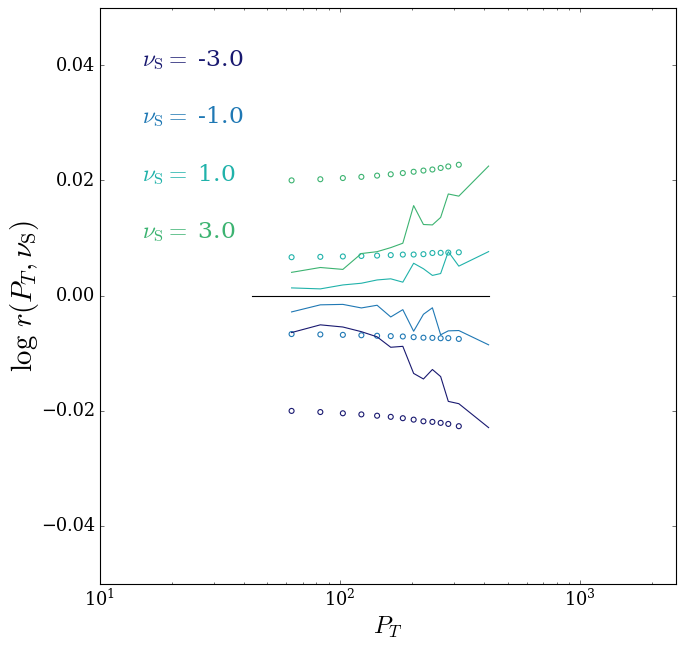

epoch: 100, loss: 0.010671, val_loss: 0.534001


/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encount

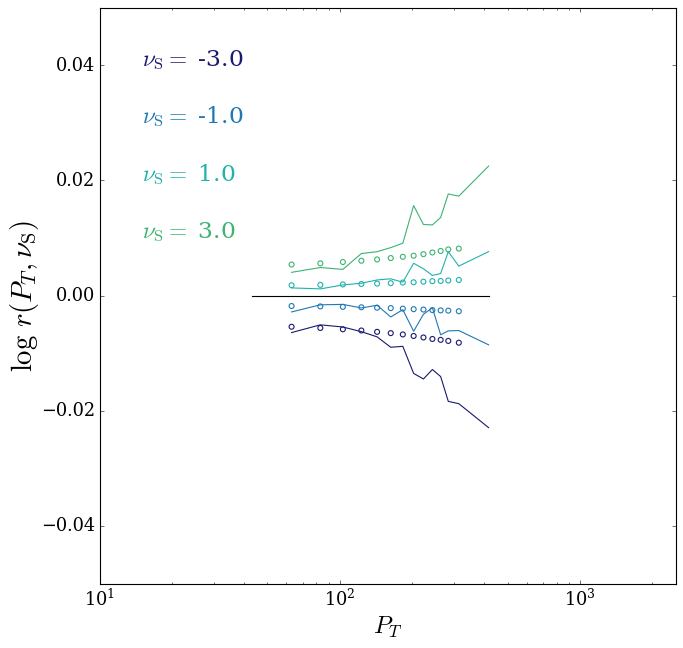

epoch: 200, loss: 0.010671, val_loss: 0.534001


/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encount

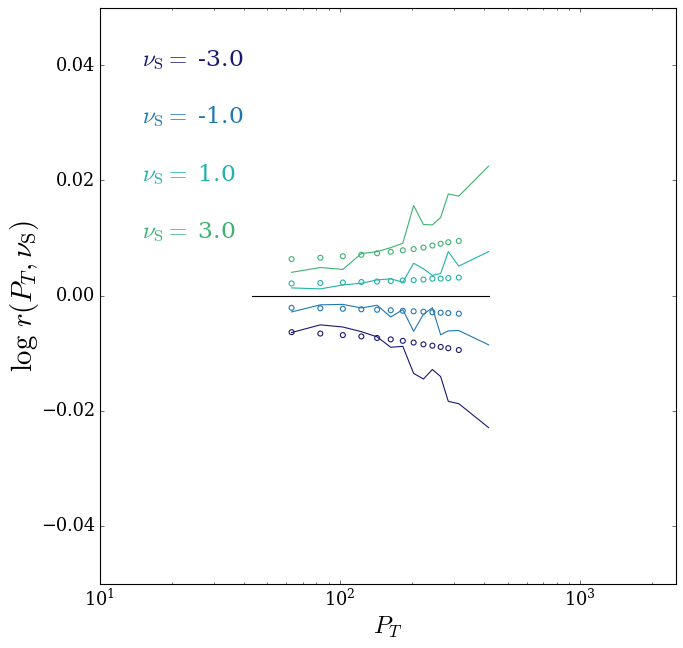

epoch: 300, loss: 0.010671, val_loss: 0.534001


/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encount

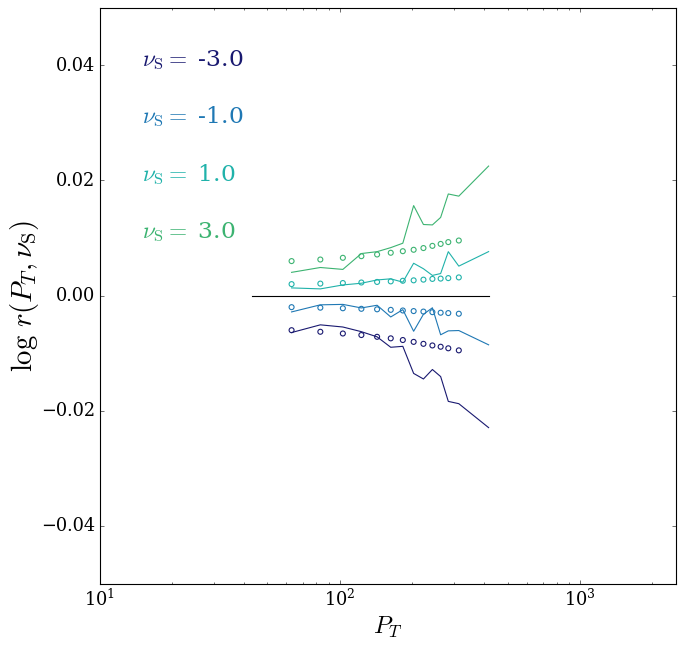

epoch: 400, loss: 0.010671, val_loss: 0.534001


/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encount

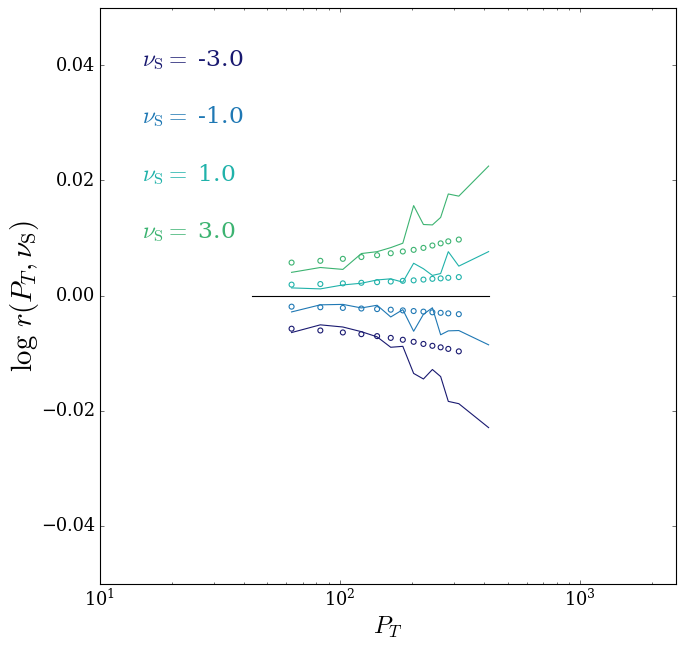

epoch: 500, loss: 0.010671, val_loss: 0.534001


/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encount

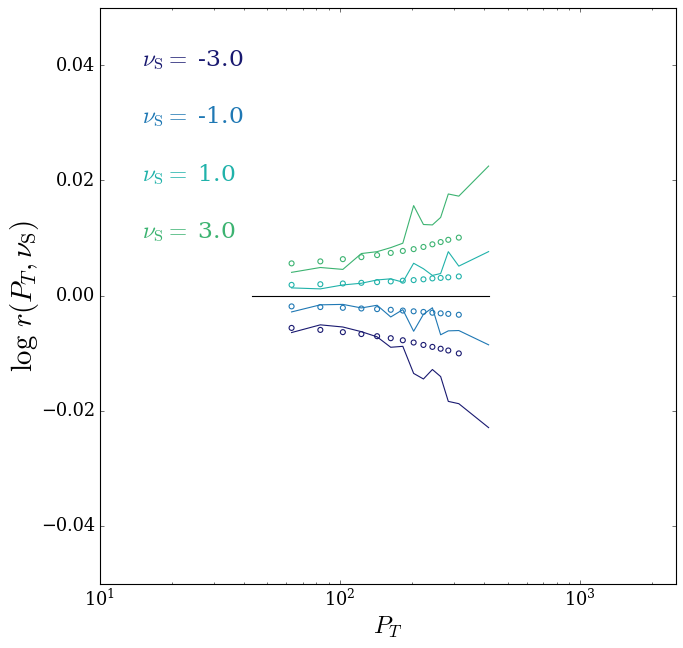

epoch: 600, loss: 0.010671, val_loss: 0.534001


/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
/tmp/hhua/ipykernel_20318/1588246858.py:78: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/hhua/ipykernel_20318/1588246858.py:94: RuntimeWarning: invalid value encount

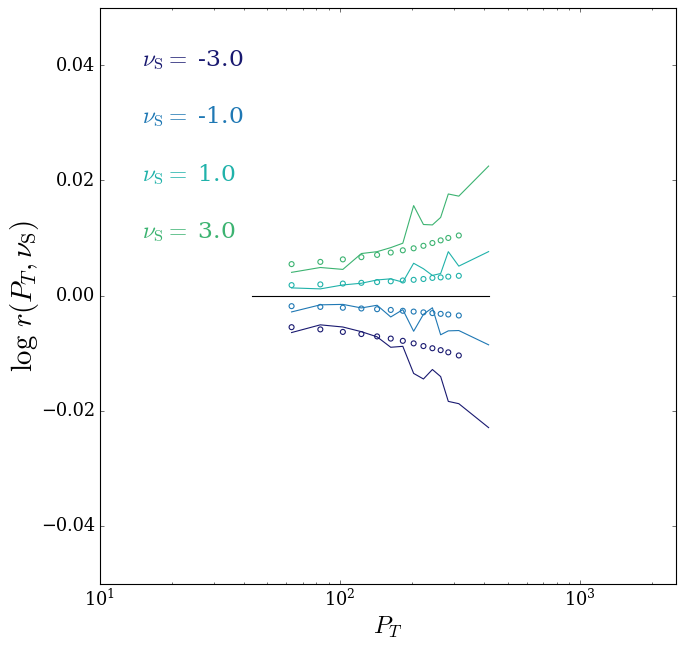

In [14]:
# training                                                                                                                                                                                     
pars_total = np.array([])
loss_total = np.array([])
loss_val_total = np.array([])

for i in range(int(total_epochs/patience)): #loop over 10
    
    loss = np.array([])
    pars = np.array([])
    train_vars = model.trainable_variables
    clipping = WeightClip(wc)#???
    #print(train_vars)
    # Create empty gradient list (not a tf.Variable list)                                                                                                                                      
    accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
    losstot, losstot_tmp = 0, 0
    for j in range(patience):
        if batch_fraction<1:
            feature_tmp, target_tmp = random_pick(feature_train[:, 0:inputsize], target_train, seed=j, fraction=batch_fraction)
        else:
            feature_tmp, target_tmp = feature_train[:, 0:inputsize], target_train
            
        with tf.GradientTape() as tape:
            pred_tmp = model(feature_tmp)
            loss_value = ParametricLoss_poly(target_tmp, pred_tmp)
            losstot += loss_value
        grads = tape.gradient(loss_value, model.trainable_variables)
        # Accumulate the gradients    
        #print(grads)
        accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, grads)]
        losstot_tmp=np.copy(losstot)
        # Now, after executing all the tapes you needed, we apply the optimization step                                                                                                        
        # (but first we take the average of the gradients)                                                                                                                                     
        if j%gather_after==0:
            accum_gradient_mean = [this_grad*1./gather_after for this_grad in accum_gradient]
            optimizer.apply_gradients(zip(accum_gradient_mean,train_vars))
            accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
            losstot = 0
        #print('batch/epoch: %i/%i, loss: %f'%(j, int(i*patience), losstot_tmp))
    for module in model.layers:
        for layer in module.layers:
            layer.set_weights([clipping(w) for w in layer.get_weights()])
    pred_val = model(feature_val[:, 0:inputsize])
    poly_val = Delta_poly(target_val, pred_val)
    loss_val = ParametricLoss_poly(target_val, pred_val)*1./gather_after
    for par in train_vars:
        pars = np.append(pars, par.numpy())
    pars = np.expand_dims(pars, axis=1).T
    loss = np.append(loss, losstot_tmp/patience)
    loss_val = np.array([loss_val])
    if pars_total.shape[0]==0:
        pars_total = pars
        loss_total = loss
        loss_val_total = loss_val
    else:
        pars_total = np.concatenate((pars_total, pars), axis=0)
        loss_total = np.concatenate((loss_total, loss), axis=0)
        loss_val_total = np.concatenate((loss_val_total, loss_val), axis=0)
    print('epoch: %i, loss: %f, val_loss: %f'%(int(i*patience), loss_total[-1], loss_val_total[-1]))
    
    # save                                                                                                                                                                                     
    f = h5py.File(OUTPUT_PATH+'/%shistory.h5'%(architecture), 'w')
    f.create_dataset('pars', data=pars_total, compression='gzip')
    f.create_dataset('loss', data=loss_total, compression='gzip')
    f.create_dataset('loss_val', data=loss_val_total, compression='gzip')
    f.close()
    log_weights = '%s/polydeg%i_L2%s_ARC%sNU%sweights_batchfrac%s_gradfreq%i_ep%i.h5'%(OUTPUT_PATH, poly_degree, str(L2), architecture, nu_string, str(batch_fraction), gather_after, i*patience)
    model.save_weights(log_weights)
    # val plot                                                                                                                                                                                 
    h_list_red = h_list # h_list seems to be the originam systematic variation
    if plot==True:
        fig      = plt.figure(figsize=(9, 9))
        fig.patch.set_facecolor('white')
        ax1    = fig.add_axes([0.1, 0.1, 0.8, 0.8])
        for k in range(len(nu_list)):
            nu = nu_list[k]
            nu_std = nu_list_std[k]
            x = 0.5*(bins[1:]+bins[:-1])
            y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))] #original hists 
            ax1.plot(x, y, label=r'muon pt scale %i $\sigma$'%(nu), color=colors[k])
            plt.text(x=15, y=0.04-0.01*k,
                 s=r'$\nu_{\rm{S}}=$ '+str(np.around(nu, 1)),
                 fontsize=21, color=colors[k], fontname="serif")
            maskR = (target_val[:, -1]==nu_std).numpy() * (target_val[:, 0]==0).numpy()
            maskD = (target_val[:, -1]==nu_std).numpy() * (target_val[:, 0]==1).numpy()
            featR = feature_val.numpy()[maskR]
            featD = feature_val.numpy()[maskD]
            deltR = np.exp(poly_val[maskR])
            weig = target_val[:, 1].numpy()
            weigR = weig[maskR]
            weigD = weig[maskD]
            hist_sumD = plt.hist(featD[:, 0]*mean_REF[0], weights=weigD, bins=bins, alpha=0.)
            hist_sumW = plt.hist(featR[:, 0]*mean_REF[0], weights=weigR*deltR, bins=bins, alpha=0.)
            hist_sum  = plt.hist(featR[:, 0]*mean_REF[0], weights=weigR,      bins=bins, alpha=0.)
            plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
            #plt.scatter(x[:-1], np.log(hist_sumD[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=10)                                                                                            
        plt.plot(x, np.zeros_like(x), color='black')
        plt.xlabel(r'$P_T$', fontsize=22, fontname="serif")
        plt.ylim(-0.05, 0.05)
        plt.xlim(10, 2500)
        plt.ylabel(r'$\log\,r(P_T,\nu_{\rm{S}})$',fontsize=26, rotation=90, labelpad=0, fontname="serif")
        plt.xticks(fontsize=16, fontname="serif")
        plt.yticks(fontsize=16, fontname="serif")
        plt.xscale('log')
        fig.savefig(log_weights.replace('.h5', '.pdf'))
        plt.show()                                                                                                                                                                            
        plt.close()



/tmp/ipykernel_620/2855898558.py:8: RuntimeWarning: divide by zero encountered in log
  y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
/tmp/ipykernel_620/2855898558.py:24: RuntimeWarning: invalid value encountered in divide
  plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')


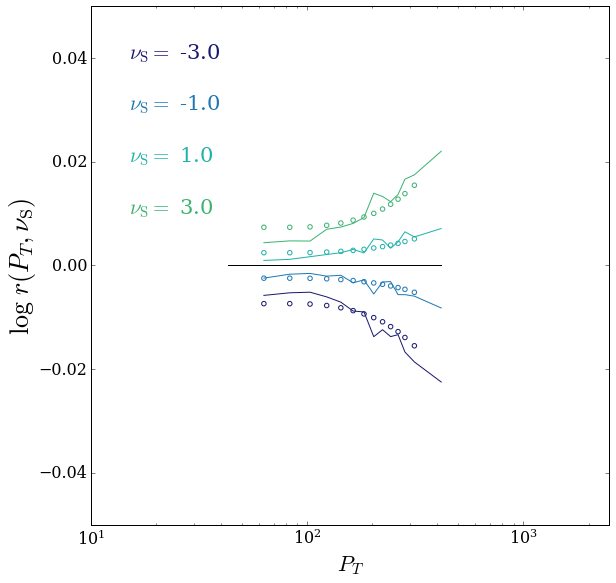

In [27]:
fig      = plt.figure(figsize=(9, 9))
fig.patch.set_facecolor('white')
ax1    = fig.add_axes([0.1, 0.1, 0.8, 0.8])
for k in range(len(nu_list)):
    nu = nu_list[k]
    nu_std = nu_list_std[k]
    x = 0.5*(bins[1:]+bins[:-1])
    y = [np.log(h_list_red[k][a]/(1e-10+h_0[a])) for a in range(len(h_0))]
    ax1.plot(x, y, label=r'muon pt scale %i $\sigma$'%(nu), color=colors[k])
    plt.text(x=15, y=0.04-0.01*k,
         s=r'$\nu_{\rm{S}}=$ '+str(np.around(nu, 1)),
         fontsize=21, color=colors[k], fontname="serif")
    maskR = (target_val[:, -1]==nu_std).numpy() * (target_val[:, 0]==0).numpy()
    maskD = (target_val[:, -1]==nu_std).numpy() * (target_val[:, 0]==1).numpy()
    featR = feature_val.numpy()[maskR]
    featD = feature_val.numpy()[maskD]
    deltR = np.exp(poly_val[maskR])
    weig = target_val[:, 1].numpy()
    weigR = weig[maskR]
    weigD = weig[maskD]
    hist_sumD = plt.hist(featD[:, 0]*mean_REF[0], weights=weigD, bins=bins, alpha=0.)
    hist_sumW = plt.hist(featR[:, 0]*mean_REF[0], weights=weigR*deltR, bins=bins, alpha=0.)
    hist_sum  = plt.hist(featR[:, 0]*mean_REF[0], weights=weigR,      bins=bins, alpha=0.)
    plt.scatter(x[:-1], np.log(hist_sumW[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=20, facecolors='none')
    #plt.scatter(x[:-1], np.log(hist_sumD[0][:-1]/hist_sum[0][:-1]), color=colors[k], s=10)                                                                                            
plt.plot(x, np.zeros_like(x), color='black')
plt.xlabel(r'$P_T$', fontsize=22, fontname="serif")
plt.ylim(-0.05, 0.05)
plt.xlim(10, 2500)
plt.ylabel(r'$\log\,r(P_T,\nu_{\rm{S}})$',fontsize=26, rotation=90, labelpad=0, fontname="serif")
plt.xticks(fontsize=16, fontname="serif")
plt.yticks(fontsize=16, fontname="serif")
plt.xscale('log')
fig.savefig(log_weights.replace('.h5', '.pdf'))
plt.show()                                                                                                                                                                            
plt.close()

In [28]:
OUTPUT_PATH

'/eos/user/g/ggrosso/PhD/DiMuon_Scouting/muonpt_parametric_training_output_2016-17-18_Mcut200_lumi100perc/'

In [29]:
log_weights = '%s/polydeg%i_L2%s_ARC%sNU%sweights_batchfrac%s_gradfreq%i_ep%i.h5'%(OUTPUT_PATH, poly_degree, str(L2), architecture, nu_string, str(batch_fraction), gather_after, i*patience)
model.save_weights(log_weights)